# The Shockley-Queisser limit

By Steven J. Byrnes. Last modified: 21 March 2016. This document lives at my website, [http://sjbyrnes.com/](http://sjbyrnes.com/). Please email me any
feedback: steven.byrnes@gmail.com

The Schockley-Queisser (SQ) limit is a famous limit on the maximal possible efficiency of solar cells, limited only by fundamental physics. It applies to most solar cell designs in the world, except for "tandem solar cells" and some additional obscure exceptions (discussed at the end of the document). The most important parameter in the SQ model is the bandgap of the semiconductor: If the gap is right, the efficiency can be up to 34%, if the gap is way off, the efficiency limit may be much smaller. [Here is the original SQ paper](http://dx.doi.org/10.1063/1.1736034), but it’s also covered in every solar-cell textbook.

I’m using NREL’s data for the solar spectrum (AM1.5G) and intensity (1000 W/m<sup>2</sup>). In the original SQ paper, they assumed that
the sun had a 6000-kelvin blackbody spectrum. So my graphs and values are slightly different. However, other papers and books
that use AM1.5G spectrum get the same results as I do, for example [link 1](http://www.opticsinfobase.org/abstract.cfm?URI=OSE-2010-SWA1), [link 2](http://www.opticsinfobase.org/abstract.cfm?URI=OSE-2010-SWC4), *Practical Handbook of Photovoltaics* p128-9,
[link 3](http://dx.doi.org/10.1109/T-ED.1984.21594).

I copied many of these graphs into the Wikipedia article on this topic - [http://en.wikipedia.org/wiki/Shockley-Queisser_limit](http://en.wikipedia.org/wiki/Shockley-Queisser_limit)

In this document you will find:

* A plot of the SQ efficiency limit as a function of bandgap
* A plot of the SQ limit on short-circuit current, on open-circuit voltage, and on fill-factor, as a function of bandgap
* A breakdown of exactly which factors lower the SQ limit for which bandgaps
* A list of some "loopholes" to exceed the SQ limit.

Enjoy!

<p style="font-size:80%">Since someone asked me: "I release this document and code to the public domain."</p>

<p style="font-size:80%">Pronunciation of "Queisser": Hans-Joachim Queisser was German, so a German-speaker helped me guess how the name is pronounced. He guesses that "Queisser" rhymes with "nicer". ("Qu" as in "quick", "ei" as in "Einstein", "ss" as in "kiss", "er" as in "teacher"). (Thanks Florian!)</p>

## General program setup

This document is a mix of text and Python code, written using [Jupyter Notebook](http://jupyter.org/) (See also [my page on installing and starting Python](http://sjbyrnes.com/python/).)

Note: If you run all the code in this file, including re-creating all the graphs, it may take a few hours. (I made no effort to write efficient code.)

In [1]:
# requires Python 3.4
import sys
assert sys.version_info >= (3,4)

Import various Python packages

In [2]:
import numpy, scipy.interpolate, scipy.integrate, urllib.request, io, tarfile

The following is a special ipython command: It defines mathematical functions like `exp` and `plot` (same as "`from pylab import *`"), and it also makes matplotlib plots display on the page:

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


One more package: A units-and-constants package I wrote: http://pypi.python.org/pypi/numericalunits

Example: <span style="color:blue">x = 5 * nu.cm</span> means "x equals 5 centimeters".

Example: <span style="color:blue">y = x / nu.mm</span> means "y is the numerical value of x in millimeters'". 

In [4]:
import numericalunits as nu

## Program inputs

Solar cell temperature is 300 kelvin:

In [5]:
Tcell = 300 * nu.K

The incident light intensity and spectrum is assumed to be the NREL AM1.5G spectrum, which approximates the light coming from the sun and sky at a typical latitude on a clear day. For more information go to http://rredc.nrel.gov/solar/spectra/am1.5/

In [6]:
data_url = 'http://rredc.nrel.gov/solar/spectra/am1.5/ASTMG173/compressed/ASTMG173.csv.tar'
download_as_bytes = urllib.request.urlopen(data_url).read()
download_as_file = io.BytesIO(download_as_bytes)
download_as_tarfile_object = tarfile.open(fileobj=download_as_file)
my_csv_file = download_as_tarfile_object.extractfile('ASTMG173.csv')
downloaded_array = numpy.genfromtxt(my_csv_file, delimiter=",", skip_header=2)

# Wavelength is in column 0, AM1.5G data is column 2
AM15 = downloaded_array[:,[0,2]]

# The first line should be 280.0 , 4.7309E-23
# The last line should be 4000.0, 7.1043E-03
print(AM15)

[[  2.80000000e+02   4.73090000e-23]
 [  2.80500000e+02   1.23070000e-21]
 [  2.81000000e+02   5.68950000e-21]
 ..., 
 [  3.99000000e+03   7.37230000e-03]
 [  3.99500000e+03   7.21000000e-03]
 [  4.00000000e+03   7.10430000e-03]]


Tack on the appropriate units:

In [7]:
AM15[:,0] *= nu.nm
AM15[:,1] *= nu.W * nu.m**-2 * nu.nm**-1

The NREL data spans the following spectral range (in terms of both photon-wavelength and photon-frequency):

In [8]:
wavelength_min = 280 * nu.nm
wavelength_max = 4000 * nu.nm
E_min = nu.hPlanck * nu.c0 / wavelength_max
E_max = nu.hPlanck * nu.c0 / wavelength_min

Interpolate to get a continuous function which I will be able to do integrals on:

In [9]:
AM15interp = scipy.interpolate.interp1d(AM15[:,0], AM15[:,1])

Here’s the plot, it looks correct:

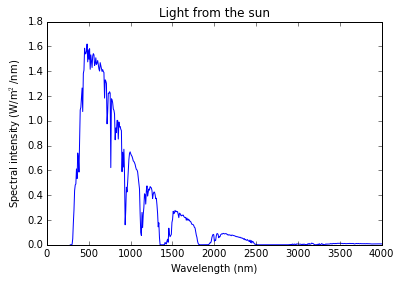

In [10]:
wavelengths = numpy.linspace(wavelength_min, wavelength_max, num=500)
y_values = numpy.array([AM15interp(x) for x in wavelengths])
plot(wavelengths / nu.nm , y_values / (nu.W / nu.m**2 / nu.nm))
xlabel("Wavelength (nm)")
ylabel("Spectral intensity (W/m$^2$/nm)")
title("Light from the sun");

## Properties of incident sunlight
### Put solar spectrum data in more convenient form
It’s a bit more convenient for me to change the units for the solar spectrum, so that I can easily do integrals over photon energy, rather than wavelength, and calculate the number of photons instead of their energy. Therefore, I’ll define the function "SPhotonsPerTEA" which stands for Solar Photons per unit Time, per unit photon Energy-range, per unit Area of the solar cell (assuming the cell is facing normal to the sun). To convert from the AM1.5 data to these new units, the formula is:

$\text{SPhotonsPerTEA} = \frac{d(\text{number of photons per unit time per unit area})}{dE} = \frac{d(\text{photon power per unit area})}{d\lambda} \; \frac{(\text{number of photons per unit time per unit area})}{(\text{photon power per unit area})} \left| \frac{d\lambda}{dE} \right| = $
$ = (\text{AM1.5 spectrum}) \; \frac{1}{\text{photon energy}} \; \frac{hc}{E^2}$

(I used $\left| \frac{d\lambda}{dE} \right| = \left| \frac{d}{dE} (\frac{hc}{E}) \right| = \frac{hc}{E^2}$.)

In [11]:
def SPhotonsPerTEA(Ephoton):
    wavelength = nu.hPlanck * nu.c0 / Ephoton
    return AM15interp(wavelength) * (1 / Ephoton) * (nu.hPlanck * nu.c0 / Ephoton**2)

Example: The following calculation means that there are $1.43 \times 10^{18}$ solar photons with energy between 2eV and 2.001eV that hit a 1-square-meter patch each second:

In [12]:
print(SPhotonsPerTEA(2 * nu.eV) * (1 * nu.meV) * (1 * nu.m**2) * (1 * nu.s))

1.4256732564e+18


Next: The "Solar constant" is the sun's total irradiance. If I did this right, it should be 1000 watts/meter$^2$, because that's how NREL normalized their data.

In [13]:
PowerPerTEA = lambda E : E * SPhotonsPerTEA(E)
# quad() is ordinary integration; full_output=1 is (surprisingly) how you hide
# the messages warning about poor accuracy in integrating.
solar_constant = scipy.integrate.quad(PowerPerTEA,E_min,E_max, full_output=1)[0]
print(solar_constant / (nu.W/nu.m**2))

999.932769213902


Close enough!

### Photons above bandgap

For a given bandgap, I’m defining a function which is the total number of solar photons with energy above the bandgap, per unit
time, per unit ground area on earth.

In [14]:
def solar_photons_above_gap(Egap):
    return scipy.integrate.quad(SPhotonsPerTEA, Egap, E_max, full_output=1)[0]

Here's an example: This means that $2.76 \times 10^{21}$ photons with energy above 1.1eV hit a one-square-meter patch of ground in one second:

In [15]:
print(solar_photons_above_gap(1.1 * nu.eV) * (1 * nu.m**2) * (1 * nu.s))

2.761918262776917e+21


Here's a plot:

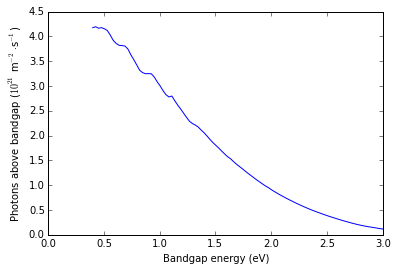

In [16]:
Egap_list = numpy.linspace(0.4 * nu.eV, 3 * nu.eV, num=100)
y_values = numpy.array([solar_photons_above_gap(E) for E in Egap_list])
plot(Egap_list / nu.eV , y_values / (1e21 * nu.m**-2 * nu.s**-1))
xlabel("Bandgap energy (eV)")
ylabel("Photons above bandgap ($10^{21}$ m$^{-2} \cdot $s$^{-1}$)");

## Solar cell recombination and J-V curve

### Recombination rate

In the best possible case, the only cause of electron-hole-pair recombination is radiative recombination. Radiative recombination occurs when an electron and hole collide, so it depends on how many electrons and holes there are, or more specifically it depends
on the electron and hole QFLs.

### Recombination rate when electron QFL = hole QFL ("QFL" is "Quasi-Fermi Level")

This is the case where electron QFL = hole QFL throughout the semiconductor. An example is the solar cell at zero bias in the dark. Then it’s in thermal equilibrium and its radiation can be calculated by the blackbody formula – more specifically, assuming it’s a perfect blackbody above the bandgap and white-body below the bandgap. We also assume isotropic radiation from the top surface, and a mirror on the bottom surface.

Let RR0 be the "Radiative Recombination rate at 0 QFL splitting", (per solar-cell area). By the blackbody formula:
$$\text{RR0} = \frac{2\pi}{c^2 h^3} \int_{E_{gap}}^{\infty} \frac{E^2 dE}{\exp(E/(k_B T_{cell})) - 1}$$

In [17]:
def RR0(Egap):
    integrand = lambda E : E**2 / (exp(E / (nu.kB * Tcell)) - 1)
    integral = scipy.integrate.quad(integrand, Egap, E_max, full_output=1)[0]
    return ((2 * pi) / (nu.c0**2 * nu.hPlanck**3)) * integral

## Recombination rate when electron QFL and hole QFL are split

By kinetic theory, the radiative recombination rate is proportional to the product of electron concentration
and hole concentration, $p\times n$. If you move the electron QFL up towards the conduction band by energy $E$,
the electron concentration increases by $\exp(-E/kT)$. Likewise, if you move the hole QFL down towards the
valence band by E, the hole concentration increases by $\exp(E/k_BT)$. Either way,
$p\times n \propto \exp(E/k_BT)$, where $E$ is the QFL energy splitting.

In the best possible case, the QFL splitting is equal to the external voltage (in reality, it may be larger
than the external voltage). Therefore, the lowest possible radiative recombaniton rate is:

$$\text{Recomb rate} = e \text{RR0} \exp(e V / k_B T_{cell}),$$

where $V$ is the external voltage.

<p style="font-size:80%">Note for pedants: I’m using the expression for radiative recombination $\frac{2\pi}{c^2 h^3} \exp(eV/k_B T_{cell})\int_{E_{gap}}^\infty \frac{E^2 dE}{\exp(E/k_B T_{cell})-1}.$ This isn't quite right: A more accurate expression is: $\frac{2\pi}{c^2 h^3} \int_{E_{gap}}^\infty \frac{E^2 dE}{\exp((E-eV)/k_B T_{cell})-1}.$ The difference is negligible except for tiny tiny bandgaps (less than 200meV). For explanation see <a href="http://dx.doi.org/10.1109/T-ED.1980.19950">link</a> or <a href="http://dx.doi.org/10.1007/BF00901283">link</a>. (Thanks Ze’ev!)</p>

## J-V curve
The current is from the electron-hole pairs that are created but which don’t recombine. In the best case, all the solar photons possible are absorbed, while none recombine except radiatively. This gives:

$$J = e (\text{SolarPhotonsAboveGap} - \text{RR0} (\exp(e V / k_B T_{cell}) - 1 ))$$

where $J$ is the current per unit area, and $V$ is the forward bias on the junction. The "-1" on the right accounts for spontaneous
generation of e-h pairs through thermal fluctuations at 300K. I will leave out the "-1" below because
$\text{RR0} \ll \text{SolarPhotonsAboveGap}$, at least in the range of bandgaps that I'm plotting.

In [18]:
def current_density(V, Egap):
    return nu.e * (solar_photons_above_gap(Egap) - RR0(Egap) * exp(nu.e * V / (nu.kB * Tcell)))

## Open-circuit voltage, short-circuit current

In [19]:
def JSC(Egap):
    return current_density(0, Egap)
def VOC(Egap):
    return (nu.kB * Tcell / nu.e) * log(solar_photons_above_gap(Egap) / RR0(Egap))

**Example:** An ideal 1.1eV-bandgap solar cell has a short-circuit current of 44 mA/cm$^2$, and an open-circuit voltage of 0.86V.

In [20]:
print(JSC(1.1 * nu.eV) / (nu.mA / nu.cm**2))
print(VOC(1.1 * nu.eV) / nu.V)

44.2508071507
0.857764576402


**Plot:**

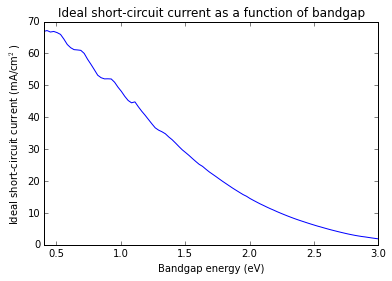

In [21]:
Egap_list = numpy.linspace(0.4 * nu.eV, 3 * nu.eV, num=100)
JSC_list = numpy.array([JSC(E) for E in Egap_list])
plot(Egap_list / nu.eV , JSC_list / (nu.mA / nu.cm**2))
xlabel("Bandgap energy (eV)")
ylabel("Ideal short-circuit current (mA/cm$^2$)")
title("Ideal short-circuit current as a function of bandgap")
xlim(0.4, 3)
ylim(0,70);

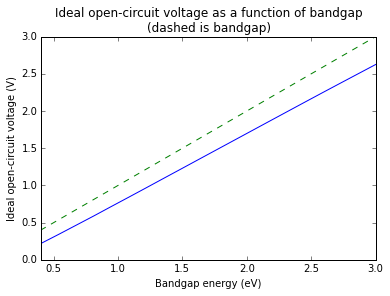

In [22]:
Egap_list = numpy.linspace(0.4 * nu.eV, 3 * nu.eV, num=20)
VOC_list = numpy.array([VOC(E) for E in Egap_list])
plot(Egap_list / nu.eV , VOC_list / nu.V,
     numpy.linspace(0,3) , numpy.linspace(0,3), '--')
xlabel("Bandgap energy (eV)")
ylabel("Ideal open-circuit voltage (V)")
title("Ideal open-circuit voltage as a function of bandgap\n(dashed is bandgap)")
xlim(0.4,3);

## Ideal bandgap and maximum efficiency

Given what we’ve already done, it’s now simple to calculate the ideal bandgap and efficiency, by numerically maximizing the product JV for each bandgap. The "maximum power point" (MPP) is the point on the JV curve at which this maximum occurs, the maximum power is the power generated at the MPP, and the efficiency is the power divided by the solar constant (i.e. incoming light power). 


In [23]:
# SciPy only comes with minimization, not maximization. Let's fix that...
from scipy.optimize import fmin

def fmax(func_to_maximize, initial_guess=0):
    """return the x that maximizes func_to_maximize(x)"""
    func_to_minimize = lambda x : -func_to_maximize(x)
    return fmin(func_to_minimize, initial_guess, disp=False)[0]

def V_mpp(Egap):
    """ voltage at max power point """
    return fmax(lambda V : V * current_density(V, Egap))

def J_mpp(Egap):
    """ current at max power point """
    return current_density(V_mpp(Egap), Egap)

def max_power(Egap):
    V = V_mpp(Egap)
    return V * current_density(V, Egap)

def max_efficiency(Egap):
    return max_power(Egap) / solar_constant

**Example:** An ideal 1.1eV-bandgap solar cell has an efficiency of 32.9%.

In [24]:
max_efficiency(1.1 * nu.eV)

0.32932950569161823

**Plot:** The famous SQ efficiency limit!


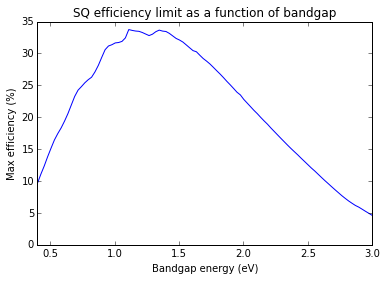

In [25]:
Egap_list = numpy.linspace(0.4 * nu.eV, 3 * nu.eV, num=100)
eff_list = numpy.array([max_efficiency(E) for E in Egap_list])
plot(Egap_list / nu.eV , 100 * eff_list)
xlabel("Bandgap energy (eV)")
ylabel("Max efficiency (%)")
title("SQ efficiency limit as a function of bandgap")
xlim(0.4, 3)
ylim(0,35);

### Fill factor

In [26]:
def fill_factor(Egap):
    return max_power(Egap) / (JSC(Egap) * VOC(Egap))

**Plot:**

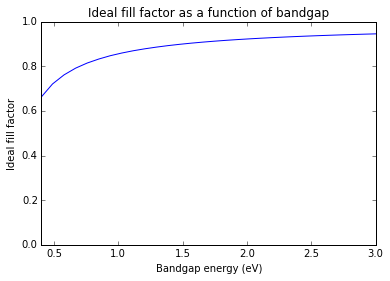

In [27]:
Egap_list = numpy.linspace(0.4 * nu.eV, 3 * nu.eV, num=30)
FF_list = numpy.array([fill_factor(E) for E in Egap_list])
plot(Egap_list / nu.eV , FF_list)
xlabel("Bandgap energy (eV)")
ylabel("Ideal fill factor")
title("Ideal fill factor as a function of bandgap")
xlim(0.4, 3)
ylim(0,1);

# Quantifying losses

We split the incoming light power into five parts:

* Power converted into useful electricity;
* Power of below-bandgap photons, which is wasted power because these photons are not absorbed;
* Excess photon energy beyond the bandgap, which is wasted because the electron and hole just immediately relax to the band edges. For example, for a 1eV-bandgap semiconductor, a 3eV photon creates the same electron-hole pair as a 1.01eV photon. All the 2eV of extra energy carried by a 3eV photon in that case is wasted.
* Power lost due to electron-hole
recombination at the max-power-point,
which is wasted as heat;
* Power lost because the voltage of the cell at the max-power-point is less than the bandgap.

To say the same thing using equations:

$(\text{Light power in}) = V_{MPP} \times I_{MPP}$<br>
$ \qquad + (\text{Power of below-bandgap photons})$<br>
$ \qquad + (\text{Power of above-bandgap photons} - \text{Number of above-bandgap photons} \times \text{Bandgap energy})$<br>
$ \qquad + ((\text{Number of above-bandgap photons}) - I_{MPP} / e) \times (\text{Bandgap energy})$<br>
$ \qquad + I_{MPP} \times (\text{Bandgap voltage} - V_{MPP})$<br>

I’ll write everything as a fraction of the incident light power.

In [28]:
def useful_electricity(Egap):
    return max_efficiency(Egap)

def below_gap_energy(Egap):
    integrand = lambda E : E * SPhotonsPerTEA(E)
    return scipy.integrate.quad(integrand, E_min, Egap, full_output=1)[0] / solar_constant

def excess_beyond_gap(Egap):
    integrand = lambda E : (E - Egap) * SPhotonsPerTEA(E)
    return scipy.integrate.quad(integrand, Egap, E_max, full_output=1)[0] / solar_constant

def mpp_recombination(Egap):
    return (solar_photons_above_gap(Egap) - J_mpp(Egap) / nu.e) * Egap / solar_constant

def mpp_voltage_is_less_than_gap(Egap):
    return J_mpp(Egap) * (Egap / nu.e - V_mpp(Egap)) / solar_constant

**Example:** Accounting for the energy and losses of an ideal 1.1eV solar cell. Everything adds up to 100% (within numerical accuracy) as expected.

In [29]:
breakdown = (useful_electricity(1.1 * nu.eV),
             below_gap_energy(1.1 * nu.eV),
             excess_beyond_gap(1.1 * nu.eV),
             mpp_recombination(1.1 * nu.eV),
             mpp_voltage_is_less_than_gap(1.1 * nu.eV))
print(breakdown)

(0.32932950569161823, 0.18753690430401876, 0.3261117679048304, 0.015803466363941275, 0.14165863398411627)


In [30]:
sum(breakdown)

1.0004402782485249

**Plot**

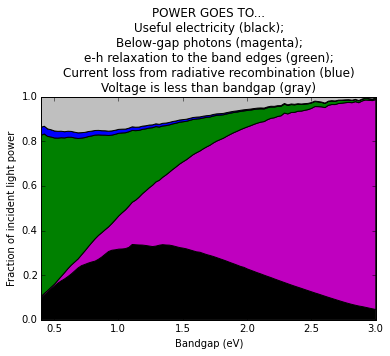

In [31]:
Egap_list = linspace(0.4 * nu.eV, 3 * nu.eV, num=100)
loss_list = [[useful_electricity(Egap), below_gap_energy(Egap), excess_beyond_gap(Egap),
                      mpp_recombination(Egap), mpp_voltage_is_less_than_gap(Egap)] for Egap in Egap_list]
loss_list = array(loss_list)
# cumulative sums to stack the contributions on top of each other
loss_list = cumsum(loss_list,axis=1)

fig = figure()
ax1 = fig.add_subplot(111)
ax1.fill_between(Egap_list / nu.eV,              0, loss_list[:,0], facecolor="k")
ax1.fill_between(Egap_list / nu.eV, loss_list[:,0], loss_list[:,1], facecolor="m")
ax1.fill_between(Egap_list / nu.eV, loss_list[:,1], loss_list[:,2], facecolor="g")
ax1.fill_between(Egap_list / nu.eV, loss_list[:,2], loss_list[:,3], facecolor="b")
ax1.fill_between(Egap_list / nu.eV, loss_list[:,3],              1, facecolor="0.75")
title('POWER GOES TO...\n'
          'Useful electricity (black);\n'
          'Below-gap photons (magenta);\n'
          'e-h relaxation to the band edges (green);\n'
          'Current loss from radiative recombination (blue)\n'
          'Voltage is less than bandgap (gray)')
xlabel('Bandgap (eV)')
ylabel('Fraction of incident light power')
xlim(0.4, 3)
ylim(0,1);

# Partial list of "loopholes" to exceed the SQ limit

Exceeding the SQ limit is a sort of obsession of solar cell physicists. The standard reference book on this subject is *Third Generation Photovoltaics* by Martin Green. Here is a partial list.

## Tandem solar cells

Tandem solar cells can and do exceed the SQ limit. In the SQ model, it is assumed that photons with energy below the bandgap are not absorbed at all, and with energy far above the bandgap are absorbed but all that excess energy is wasted. A tandem solar cell allows high-energy photons to excite a large-bandgap solar cell, and lower-energy photons to excite a smaller-bandgap solar cell. Usually 2 or 3 or 4 solar cells are used. Tandem solar cells are widely used and available. They are used commercially to make the very highest-efficiency most-expensive solar cells. They are also used commercially in some lower-end solar cells, such as amorphous silicon.

In the above derivation, where exactly is the loophole that tandem cells take advantage of? It is the step where I wrote "In the best possible case, the QFL splitting is equal to the external voltage (in reality, it may be larger than the external voltage)." Normally, this is true because, to get a net flow of photogenerated electrons into the cathode lead, the electron QFL has to tilt downward towards the cathode lead, and likewise to get a net flow of photogenerated holes into the anode lead, the hole QFL has to tilt upwards towards the cathode lead. However, in a tandem cell, the QFLs repeatedly split apart and come back together, such that the external voltage can be much greater than the QFL splitting at any given point.

## Light concentration

The sun is a small point in the sky, so sunlight can be focused to very high concentrations (in theory as much as 50,000X!) Higher concentrations generally lead to higher efficiencies, assuming the solar panel does not heat up too much. In other words, if you focus sunlight to make it 100X more intense on a solar cell, the power can go up by *more* than 100X in the SQ model. Although light concentration is commonly used in practice for solar cells, the possible modest efficiency gain is *not* the *primary* reason that concentrated solar cells are used, in my understanding. More important is that small solar cells with huge mirrors/lenses can sometimes be cheaper than huge solar cells with no mirrors/lenses.

## Anisotropic radiation

If you engineer a solar cell to only radiate in one direction, its theoretical efficiency increases. (The direction it radiates has to point towards the sun, otherwise light cannot get in.) The theoretical increase here is the same as if you were doing light-concentration. Unfortunately, in practice, it is not as helpful as you might hope, because it reduces radiative recombination but does not reduce nonradiative recombination.

## Hot electrons

Electrons are usually excited to an energy far above the conduction-band-minimum, and holes far below the valence-band-maximum. Usually they relax to the band edges very quickly. If you can stop that relaxation, you can theoretically exceed the SQ limit by a lot. It seems to be very difficult in practice, and so far there is not even a proof-of-principle laboratory demonstration of a complete hot-electron device.

## Multiple-exciton generation

In the SQ calculation, it is assumed that each photon above the bandgap creates just one electron-hole pair. In theory, a photon at twice the bandgap could produce two e-h pairs, at 3X the bandgap could produce 3, etc. This is called "Multiple-exciton generation" (MEG). There has been a lot of work on this in recent years, particularly in quantum dots, and for many years there was controversy over whether MEG had been observed. The "smoking gun" for MEG–i.e., unarguable proof of its occurrance–is a device with "external quantum efficiency" above 100% (i.e., more than one electron flows through the ammeter, for each photon coming into the device). After a lot of work, that milestone was finally reached in December 2011: [link](http://dx.doi.org/10.1126/science.1209845). So now we know for sure that MEG is possible in some devices. Of course, we are still a long way away from seeing a commercial device that takes advantage of MEG.

## Intermediate-band solar cell

In the SQ calculation, it is assumed that photons below the bandgap are wasted. Instead, it is possible to have an energy level in the gap, and excite electrons from the valence to conduction band in two steps. There have been a few laboratory proof-of-principle demonstrations of the concept: [link 1](http://dx.doi.org/10.1103/PhysRevLett.106.028701), [link 2](http://dx.doi.org/10.1063/1.3166863), [link 3](http://dx.doi.org/10.1103/PhysRevLett.97.247701). So far there is no demonstration that intermediate-band solar cells can have high efficiencies in practice.

## Chemical upconversion

In the SQ calculation, it is assumed that photons below the bandgap are wasted. Instead, it is possible to incorporate an upconversion chemical that absorbs two low-energy photons and emits one high-energy photon. Such chemicals exist, and upconverting solar cells have been demonstrated, but so far these have not been incorporated into commercial solar cells, I think primarily because the chemicals are expensive rare-earth compounds, and they can only upconvert within a narrow wavelength range. (But I’m not sure.)

## Chemical downconversion

In the SQ calculation, it is assumed that each photon above the bandgap creates just one electron-hole pair. In theory, a photon at twice the bandgap could produce two e-h pairs, at 3X the bandgap could produce 3, etc. The idea of "downconversion" is to incorporate a downconversion chemical that absorbs one very-high-energy photon and re-radiates two lower-energy photons (lower-energy but still above the bandgap) that add up to the energy of the original photon. The system is only worthwhile if each incoming high-energy photon is converted to *more than 1 on average* outgoing above-bandgap photon. This requires high downconversion efficiency and very low loss, and this benchmark that has not yet been reached (as far as I know).

## Non-blackbody solar cell and "photon recycling"

Say you have a material with too small a bandgap, like 0.5eV, but you want it to use it in a solar cell anyway. You are at a disadvantage because the Shockley-Queisser efficiency limit for 0.5eV bandgap is much lower than the limit for, say, 1.2eV bandgap. However, what you can do is put your solar cell behind a dichroic mirror or coating which reflects all light with frequency below 1.2eV and transmits all light with frequency above 1.2eV. If you do this, the 0.5eV-bandgap material behaves as if it had a 1.2eV bandgap, and in particular it has the same theoretical efficiency limit as if it had a 1.2eV bandgap. What’s happening is that most of the photons emitted in electron-hole recombination events in the semiconductor are reflected right back into the semiconductor, where they are reabsorbed into a new electron-hole pair. Therefore you can get a huge density of electrons and holes with very little net radiative recombination. These electrons and holes fill up the conduction and valence bands until the "Dynamic Burstein-Moss"-shifted bandgap is close to 1.2eV. Another way to look at it is, you have made the material into a whitebody below 1.2eV and a blackbody above 1.2eV, which is the same as a 1.2eV bandgap material. See [link](http://dx.doi.org/10.1063/1.3682101) for more details.

More generally, when a radiative recombination photon is re-absorbed to make a new electron-hole pair, as in the previous paragraph, it’s sometimes called "Photon recycling". Photon recycling is important for modeling solar cells, for example <a href="http://dx.doi.org/10.1016/0927-0248(93)90142-P">link</a>. However, photon recycling cannot on its own make a solar cell overcome the overall Shockley-Queisser limit of ~34%. (An exception is the anisotropic radiation design, see above.) Moreover, photon recycling reduces net radiative recombination, but does not reduce nonradiative recombination, so it’s not as helpful as you might otherwise hope.